In [1]:
from tensorflow import keras
from PIL import Image
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
import torch
import random
from torchvision import models, transforms
from scipy.spatial import distance_matrix
import numpy as np

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [3]:
toTensor = transforms.ToTensor()

sample_size = 80
xSub = x_train[:sample_size]
ySub = y_test[:sample_size]

xTensor = toTensor(xSub)
xTensor = xTensor.permute(1, 0, 2).reshape(len(xSub), 1, 28, 28) # shape: (28, sample_size, 28) -->  shape: (sample_size, 1, 28, 28)

In [4]:
negative_i_dict = {}

for label in set(ySub):
    negative_i_dict[label] = [i for i in range(len(ySub)) if ySub[i] != label ]

negative_i_dict

{0: [0,
  1,
  2,
  4,
  5,
  6,
  7,
  8,
  9,
  11,
  12,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  26,
  27,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  70,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79],
 1: [0,
  1,
  3,
  4,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  30,
  32,
  33,
  34,
  35,
  36,
  38,
  41,
  42,
  43,
  44,
  45,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  75,
  76,
  77,
  78,
  79],
 2: [0,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
 

In [5]:
margin = 32

model = nn.Sequential(  nn.Flatten(),
                        nn.Linear(28*28,512),
                        nn.ReLU(),
                        nn.Linear(512,256),
                        nn.ReLU(),
                        nn.Linear(256,32),
                        nn.Sigmoid()
                        )

optimizer = optim.SGD( model.parameters() )
criterion = nn.TripletMarginLoss(p=1, # Manhatten Distance
                                 margin=margin
                                 )

In [6]:
def getAPN(a, pos, dMatrix):
    aP = [a]+pos
    neg_i = [i for i in range(len(dMatrix)) if i not in aP ]

    outPut = []

    for p in  pos:
        posDist = dMatrix[a][p]
        
        legal_i = [i for i in neg_i if posDist < dMatrix[a][i] <= posDist+margin] # i = "global" index of the Hash
        
        legal_dist = [dMatrix[a][i] for i in legal_i]
        
        if legal_dist == []: continue
        max_dist = min(legal_dist)

        n = legal_i[ legal_dist.index(max_dist) ]
        outPut.append( (a, p, n) )

    return outPut

In [42]:
import random

batchSize = 40

outOfBatch_sampleSize = 20

for qwe in range(5000):

    for i in list(range(0, len(xSub) , batchSize)):
        giBatchStart = i
        giBatchEnd = i + batchSize

        giBatchRange = range(giBatchStart, giBatchEnd)
        giNotInBatch = [j for j in range(len(xSub)) if j not in giBatchRange]

        giNotInBatch_sample = random.sample(giNotInBatch,outOfBatch_sampleSize)

        xBatch = xTensor[giBatchStart:giBatchEnd]
        yBatch = ySub[giBatchStart:giBatchEnd]

        batchResults =  model(xBatch).detach().numpy()
        sampleResults = model( torch.stack( [xTensor[j] for j in giNotInBatch_sample] ) ).detach().numpy()

        aMatrix = distance_matrix(batchResults, batchResults , p=1)
        sMatrix = distance_matrix(batchResults, sampleResults , p=1)

        for label in set(yBatch):
            aLabels = yBatch
            sLabels = [ySub[j] for j in giNotInBatch_sample]


            labels = list(aLabels)+list(sLabels)

            print(labels)



            break

        
    break
 
    """
        results = model(xBatch)
        results_np = results.detach().numpy()

        dMatrix = distance_matrix(results_np, results_np, p=1)

        APN_list = []

        for label in set(yBatch):
            pos_i_list = [j for j in range(len(yBatch)) if yBatch[j] == label]

            for anchor_i in pos_i_list:
                pos_i = [j for j in pos_i_list if j != anchor_i]

                APN_list += getAPN(anchor_i, pos_i, dMatrix)


        a_list = []
        p_list = []
        n_list = []

        for apn in APN_list:
            a_list.append(results[ apn[0] ])
            p_list.append(results[ apn[1] ])
            n_list.append(results[ apn[2] ])
        
        # === Improve Model ===
        optimizer.zero_grad()

        loss = criterion(torch.stack(a_list),
                        torch.stack(p_list),
                        torch.stack(n_list) )
        
        loss.backward()
        optimizer.step()

        print(qwe ,i, loss)
    """

[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 0, 0, 9, 6, 3, 2, 4, 3, 7, 2, 1, 5, 2, 3, 4, 4, 3, 4, 3, 8]
[1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 0, 4, 7, 9, 7, 5, 7, 1, 1, 4, 0, 0, 6, 4, 2, 0, 1, 5, 1, 3]


In [37]:
sMatrix[0][39]

IndexError: index 39 is out of bounds for axis 0 with size 20

array([[0.49310538, 0.5030828 , 0.51538247, ..., 0.49773353, 0.5162316 ,
        0.4747206 ],
       [0.4908589 , 0.50148785, 0.5264482 , ..., 0.4997181 , 0.51621234,
        0.47689387],
       [0.50363266, 0.5138944 , 0.5123734 , ..., 0.49463394, 0.5116208 ,
        0.47572428],
       ...,
       [0.4947154 , 0.49907184, 0.5114406 , ..., 0.49422008, 0.5166716 ,
        0.47893324],
       [0.49463186, 0.5028424 , 0.5078511 , ..., 0.49653634, 0.5213906 ,
        0.48002413],
       [0.4898813 , 0.5030491 , 0.51808816, ..., 0.49598053, 0.5224003 ,
        0.48044455]], dtype=float32)

In [13]:
torch.stack( [xTensor[j] for j in giNotInBatch_sample] )

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

# Step 1: Perform K-Means Clustering
def kmeans_clustering(hash_codes, n_clusters=10, n_init=10, random_state=42):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, random_state=random_state)
    clusters = kmeans.fit_predict(hash_codes)
    return clusters

# Step 2: Build the label-cluster matrix
def build_label_cluster_matrix(clusters, true_labels, n_clusters=10):
    # Initialize a matrix to count label-cluster relationships  
    label_cluster_matrix = np.zeros((10, n_clusters), dtype=int)
    
    for label, cluster in zip(true_labels, clusters):
        label_cluster_matrix[label][cluster] += 1
    
    return label_cluster_matrix

# Step 3: Visualize the result as a heatmap
def plot_heatmap(label_cluster_matrix):
    plt.figure(figsize=(10, 6))
    sns.heatmap(label_cluster_matrix, annot=True, fmt="d", cmap="Blues", cbar=True)
    plt.title("Label Distribution Across Clusters")
    plt.xlabel("Clusters")
    plt.ylabel("True Labels")
    plt.show()


def easyHeatmap(hashCodes, labels):
    raw_clusters = kmeans_clustering(hashCodes, n_clusters=10)

    raw_label_cluster_matrix = build_label_cluster_matrix(raw_clusters, labels)

    plot_heatmap(raw_label_cluster_matrix)

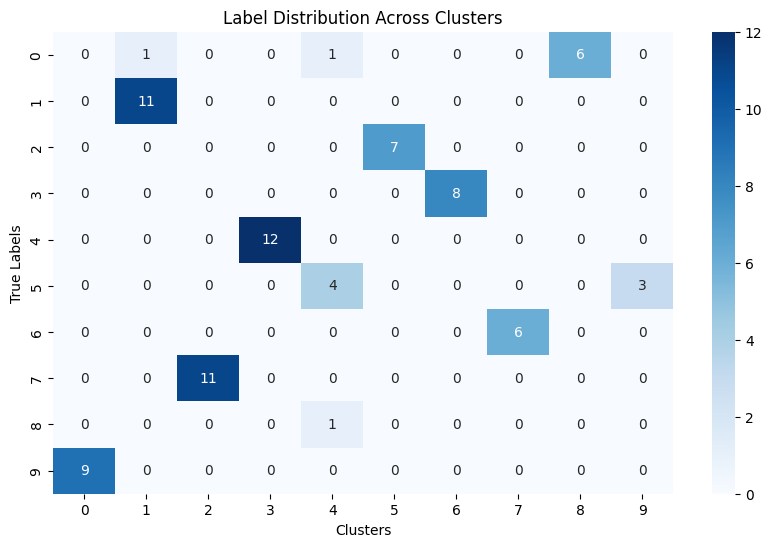

In [10]:
easyHeatmap(model(xTensor).detach().numpy(), ySub)

In [15]:
toTensor = transforms.ToTensor()

sample_size = 5000
xSub = x_train[:sample_size]
ySub = y_test[:sample_size]

xTensor = toTensor(xSub)
xTensor = xTensor.permute(1, 0, 2).reshape(len(xSub), 1, 28, 28) # shape: (28, sample_size, 28) -->  shape: (sample_size, 1, 28, 28)

xBatch = xTensor

results = model(xBatch)
results_np = results.detach().numpy()

dMatrix = distance_matrix(results_np, results_np, p=1)


In [16]:
len(xTensor)

5000

In [78]:
toTensor = transforms.ToTensor()

sample_size = 20
xSub = x_train[:sample_size]
ySub = y_test[:sample_size]

xTensor = toTensor(xSub)
xTensor = xTensor.permute(1, 0, 2).reshape(len(xSub), 1, 28, 28) # shape: (28, sample_size, 28) -->  shape: (sample_size, 1, 28, 28)

xBatch = xTensor

results = model(xBatch)
results_np = results.detach().numpy()

dMatrix = distance_matrix(results_np, results_np, p=1)
dMatrix.shape

(20, 20)

In [79]:
import copy

In [82]:
MARGGIN = 16

label = 5
labels = ySub

ap_dist = 0.15

row = copy.deepcopy( dMatrix[0] )

for i in range(sample_size):
    if ap_dist + MARGGIN < row[i]: row[i] = 0   # Only look at cases where negative is closer than postive (plus Margin)
    if labels[i] == label: row[i] = 0           #
    if not (ap_dist < row[i]): row[i] = 0       # Only looking at semi-Hard Negatives

n_index = list(row).index( max(row) ) # Local index of the longest distance

0 0.0 False
1 0.15258637070655823 True
2 0.20685115456581116 True
3 0.14551237225532532 False
4 0.176702082157135 True
5 0.17393526434898376 True
6 0.18926304578781128 True
7 0.12374520301818848 False
8 0.20430919528007507 True
9 0.17689135670661926 True
10 0.16680529713630676 True
11 0.15661883354187012 True
12 0.1925264298915863 True
13 0.15240365266799927 True
14 0.18056800961494446 True
15 0.13803905248641968 False
16 0.13477113842964172 False
17 0.11712571978569031 False
18 0.1680614948272705 True
19 0.14877742528915405 False


In [83]:
row

array([0.        , 0.15258637, 0.20685115, 0.        , 0.17670208,
       0.17393526, 0.18926305, 0.        , 0.        , 0.17689136,
       0.1668053 , 0.15661883, 0.19252643, 0.15240365, 0.18056801,
       0.        , 0.        , 0.        , 0.16806149, 0.        ])